
🔍 Analyzing sentiment for AAPL...
📰 Analyzing 100 headlines...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-5b5d0b39e4a5>:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


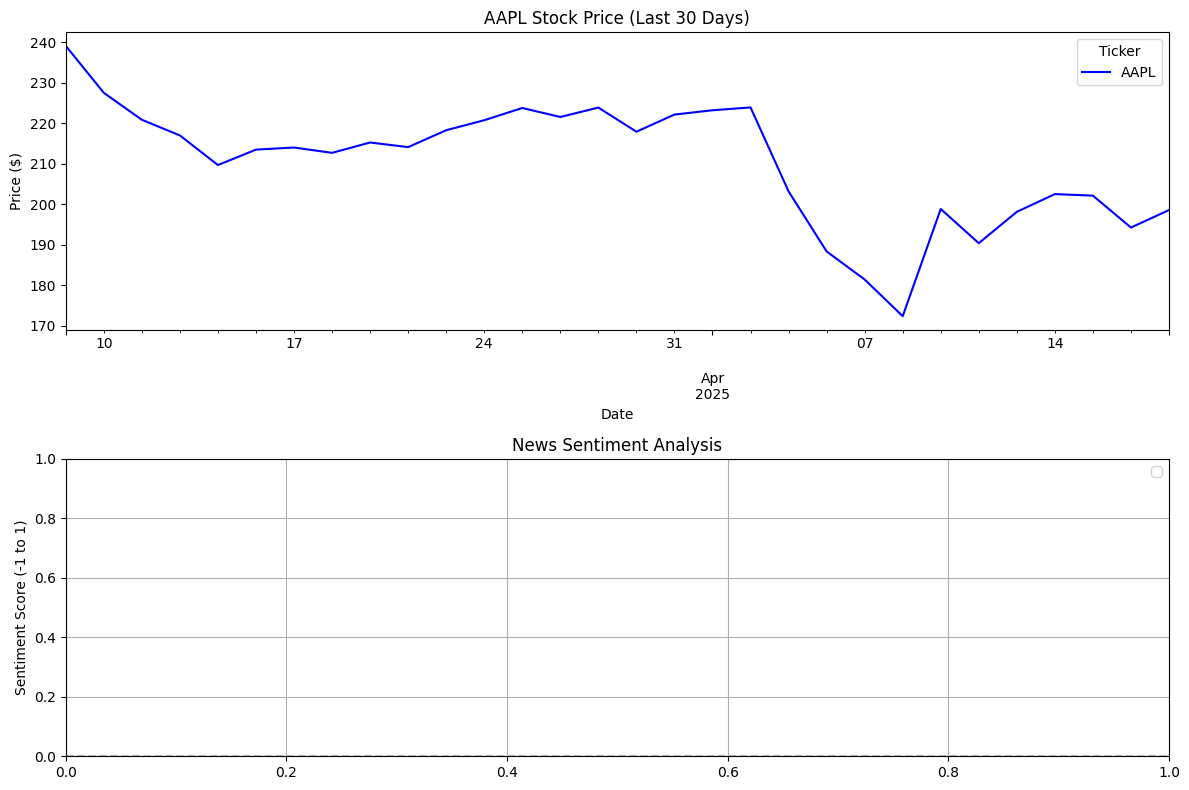


✅ Analysis complete!


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline


import nltk
nltk.download('vader_lexicon', quiet=True)

# ===== USER INPUTS =====
TICKER = "AAPL"
LOOKBACK_DAYS = 30
NEWS_SOURCE = "finviz"
MIN_HEADLINES = 5

# ===== IMPROVED FUNCTIONS =====
def scrape_finviz_news(ticker):
    """Scrape news headlines from Finviz with error handling"""
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0'}

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        news_table = soup.find('table', {'id': 'news-table'})

        headlines = []
        if news_table:
            for row in news_table.find_all('tr'):
                td_text = row.td.get_text().split('  ')
                if len(td_text) > 1:
                    date = td_text[0].strip()
                    headline = ' '.join(td_text[1:]).strip()
                    headlines.append({'date': date, 'headline': headline})

        return pd.DataFrame(headlines) if headlines else pd.DataFrame()

    except Exception as e:
        print(f"⚠️ Error scraping Finviz: {str(e)[:100]}...")
        return pd.DataFrame()

def analyze_sentiment(text, analyzer):
    """Analyze sentiment with error handling"""
    try:
        if analyzer == "nltk":
            sia = SentimentIntensityAnalyzer()
            return sia.polarity_scores(text)['compound']
        else:
            classifier = pipeline("sentiment-analysis",
                                model="distilbert-base-uncased-finetuned-sst-2-english",
                                device=-1)
            result = classifier(text[:512])[0]
            return result['score'] * (1 if result['label'] == 'POSITIVE' else -1)
    except:
        return 0

# ===== MAIN ANALYSIS =====
print(f"\n🔍 Analyzing sentiment for {TICKER}...")


news_df = scrape_finviz_news(TICKER) if NEWS_SOURCE == "finviz" else scrape_yahoo_finance_news(TICKER)

if len(news_df) < MIN_HEADLINES:
    print(f"⚠️ Only {len(news_df)} headlines found. Try a different news source or ticker.")
else:

    print(f"📰 Analyzing {len(news_df)} headlines...")
    news_df['nltk_sentiment'] = news_df['headline'].apply(lambda x: analyze_sentiment(x, "nltk"))
    news_df['transformer_sentiment'] = news_df['headline'].apply(lambda x: analyze_sentiment(x, "transformers"))


    prices = yf.download(TICKER, period=f"{LOOKBACK_DAYS}d")['Close']


    if 'date' in news_df.columns:
        try:
            news_df['date'] = pd.to_datetime(news_df['date']).dt.date
            daily_sentiment = news_df.groupby('date')[['nltk_sentiment', 'transformer_sentiment']].mean()
        except:
            daily_sentiment = pd.DataFrame({
                'nltk_sentiment': [news_df['nltk_sentiment'].mean()],
                'transformer_sentiment': [news_df['transformer_sentiment'].mean()]
            })
    else:
        daily_sentiment = pd.DataFrame({
            'nltk_sentiment': [news_df['nltk_sentiment'].mean()],
            'transformer_sentiment': [news_df['transformer_sentiment'].mean()]
        })


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))


    prices.plot(ax=ax1, color='blue')
    ax1.set_title(f"{TICKER} Stock Price (Last {LOOKBACK_DAYS} Days)")
    ax1.set_ylabel("Price ($)")


    if len(daily_sentiment) > 1:
        daily_sentiment['nltk_sentiment'].plot(ax=ax2, color='green', label='NLTK Sentiment')
        daily_sentiment['transformer_sentiment'].plot(ax=ax2, color='orange', label='Transformer Sentiment')
    else:
        if not daily_sentiment.empty:
            ax2.axhline(daily_sentiment['nltk_sentiment'].values[0], color='green', label='NLTK Sentiment')
            ax2.axhline(daily_sentiment['transformer_sentiment'].values[0], color='orange', label='Transformer Sentiment')

    ax2.set_title("News Sentiment Analysis")
    ax2.set_ylabel("Sentiment Score (-1 to 1)")
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("\n✅ Analysis complete!")